### Листинг 1.1. Построение гистограмм изображения.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [110]:
hist_size = 256
hist_range = (0, 256)
color = ('b', 'g', 'r')

image = cv2.imread("MIT_mini_Cheetah.jpg")

print(f'Размер изображения: {image.shape[:2]}, имеющего {image.shape[2]} канала')
print(f'MAX: {max(image.reshape(-1))}\nMIN: {min(image.reshape(-1))}')

Размер изображения: (1536, 2048), имеющего 3 канала
MAX: 97
MIN: 0


In [111]:
def show_image_hist(image):
    fig, axis = plt.subplots(1, 2, figsize=(15, 5))

    axis[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axis[0].axis('off')
    axis[1].set_xlim([0,255])
    
    image_BGR = cv2.split(image)
    for i, col in enumerate(color):
        hist = cv2.calcHist(image_BGR, [i], None, [hist_size], hist_range)
        axis[1].plot(hist, color = col)

    plt.show()

Базовая гистограмма

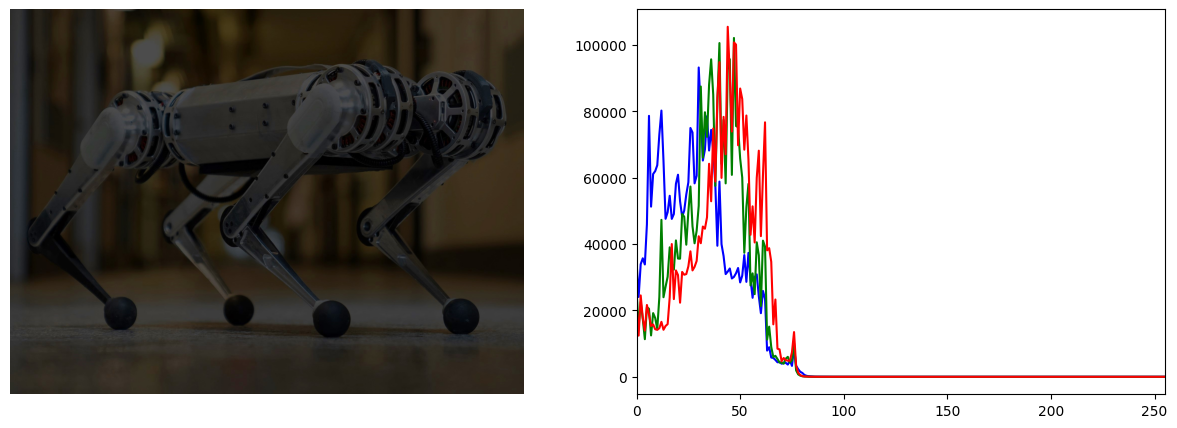

In [112]:
show_image_hist(image)

Как видно из гистограммы, на изображении преобладают пиксели с темными оттенками

### Листинг 1.2. Арифметические операции.

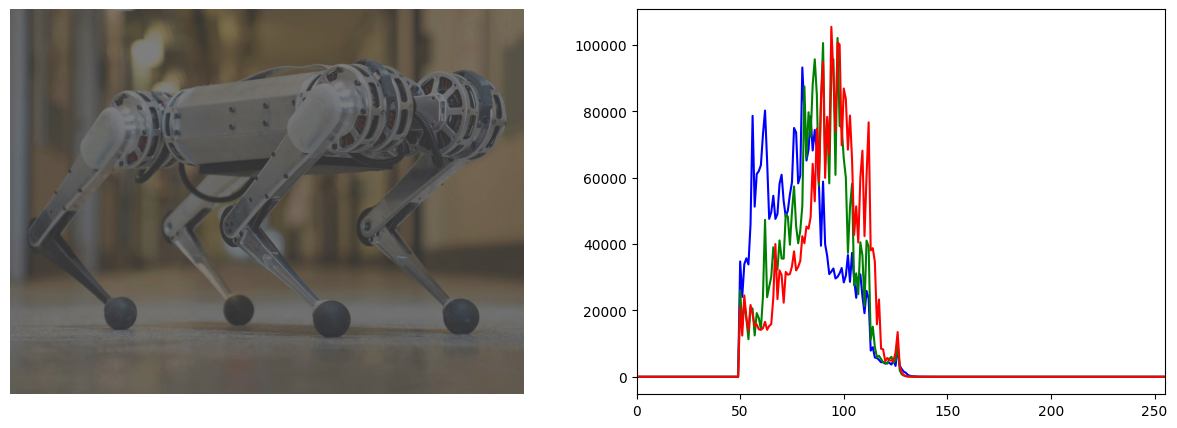

In [113]:
bias = 50
show_image_hist((image + bias) % 255)

После сдвига гистограммы вправо на 50 градаций, стали более различимы темные объекты робота

### Листинг 1.3. Растяжение динамического диапазона

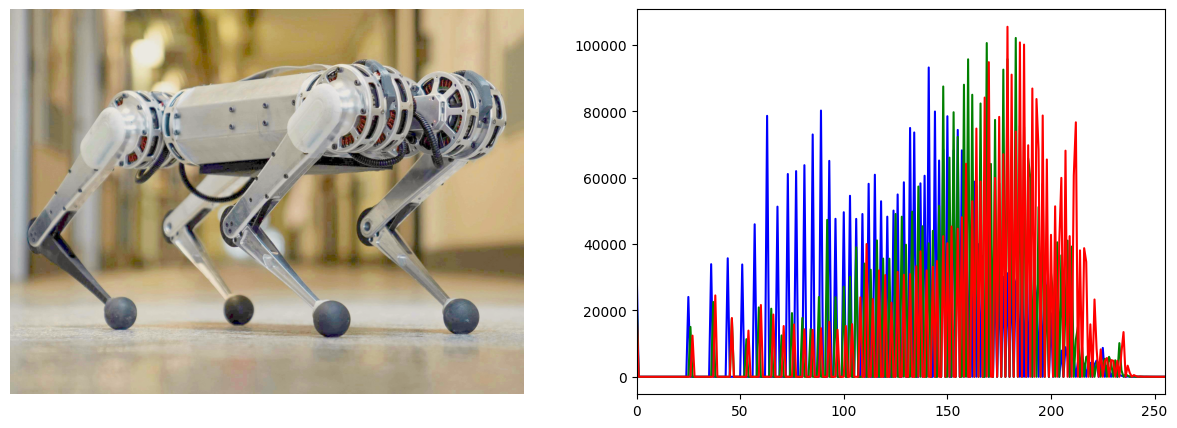

In [114]:
image_new = image.astype(np.float32) / 255
alfa = 0.5

image_BGR = cv2.split(image_new)
image_new_BGR = list()

for layer in image_BGR:
    Imin = layer.min()
    Imax = layer.max()
    image_new = np.clip((((layer - Imin) / (Imax - Imin))**alfa), 0, 1)

    image_new_BGR.append(image_new)

image_new = cv2.merge(image_new_BGR)

image_new = (255 * image_new).clip(0, 255).astype(np.uint8)

show_image_hist(image_new)

### Листинг 1.4. Равномерное преобразование

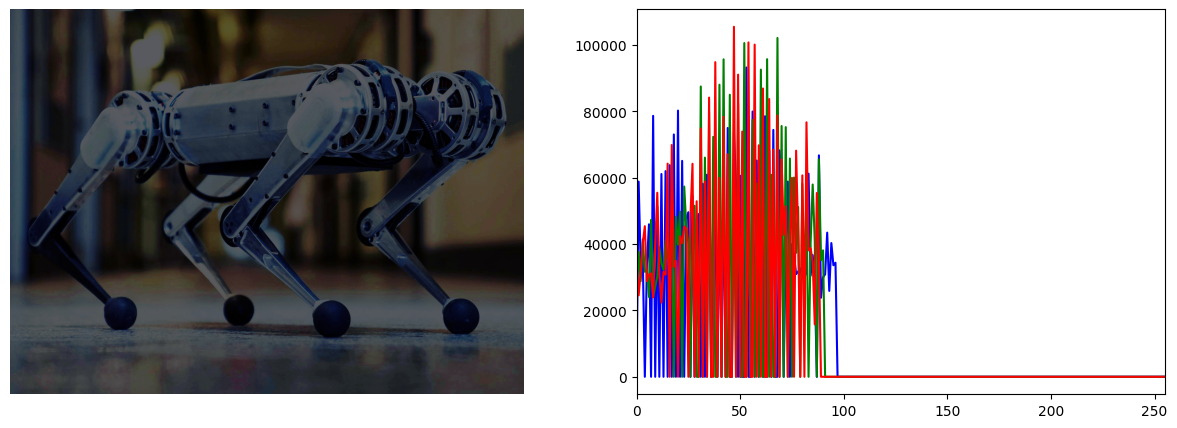

In [125]:
base_hist = []
CH = []

image_BGR = cv2.split(image)

for i, col in enumerate(color):
    base_hist.append(cv2.calcHist(image_BGR, [i], None, [hist_size], hist_range))
    CH.append(np.cumsum(base_hist[i]) / (image.shape[0] * image.shape[1]))

image_new = []
image_new_BGR = []

for i, layer in enumerate(image_BGR):
    Imin = layer.min()
    Imax = layer.max()

    image_new = np.clip(((Imax - Imin) * CH[i][image[:, :, i]] + Imin), 0, 255)
    image_new_BGR.append(image_new)

image_new = cv2.merge(image_new_BGR)
image_new = image_new.astype(np.uint8)

show_image_hist(image_new)


Изображение стало более насыщенным

Проверка ручным способом

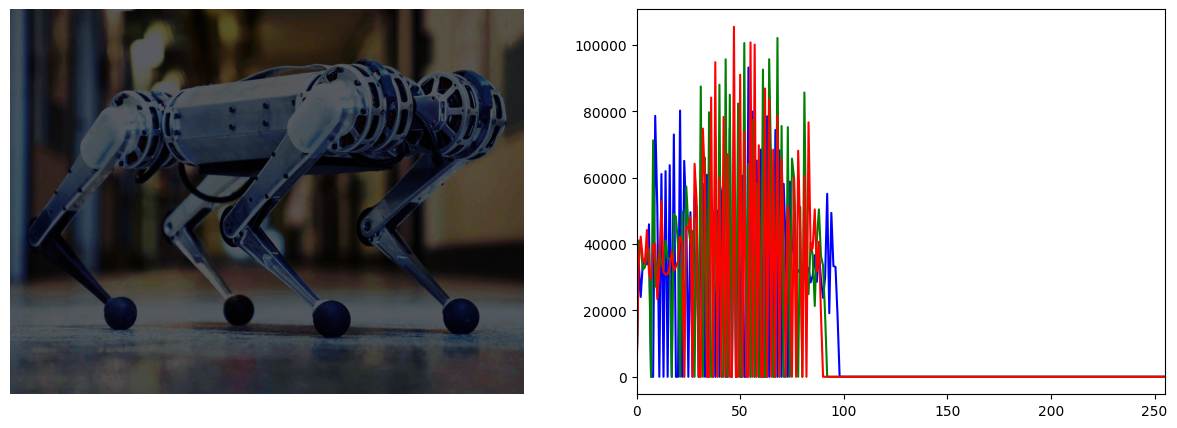

In [116]:
# Проверка ручным способом
base_hist = []
CH = []

image_BGR = cv2.split(image)

for i, col in enumerate(color):
    base_hist.append(cv2.calcHist(image_BGR, [i], None, [hist_size], hist_range))
    CH.append(np.cumsum(base_hist[i]) / (image.shape[0] * image.shape[1]))

Imin = [np.min(image[:,:,i]) for i in range(image.shape[2])]
Imax = [np.max(image[:,:,i]) for i in range(image.shape[2])]
image_new = np.zeros(image.shape, dtype="uint8")

for i in range(image.shape[2]):
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            Inew = (Imax[i] - Imin[i]) * CH[i][image[y][x][i]] + Imin[i]
            if Inew < 0:
                Inew = 0
            if Inew > 255:
                Inew = 255
            image_new[y][x][i] = int(round(Inew))
            
show_image_hist(image_new)

Проверим равномерное преобразование на черно-белом изображении

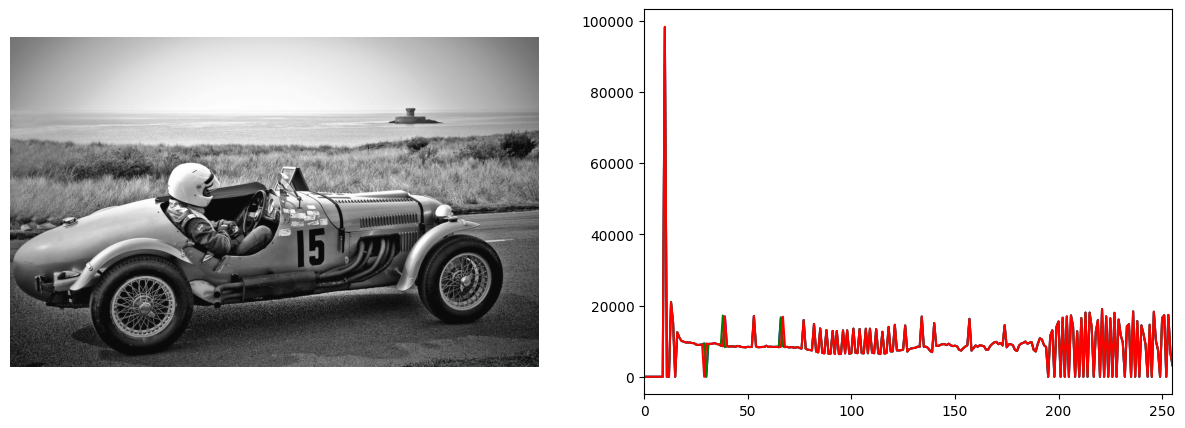

In [122]:
image_test = cv2.imread("test.jpg")

base_hist = []
CH = []

image_BGR = cv2.split(image_test)

for i, col in enumerate(color):
    base_hist.append(cv2.calcHist(image_BGR, [i], None, [hist_size], hist_range))
    CH.append(np.cumsum(base_hist[i]) / (image_test.shape[0] * image_test.shape[1]))

image_new = []
image_new_BGR = []

for i, layer in enumerate(image_BGR):
    Imin = layer.min()
    Imax = layer.max()

    image_new = np.clip(((Imax - Imin) * CH[i][image_test[:, :, i]] + Imin), 0, 255)
    image_new_BGR.append(image_new)

image_new = cv2.merge(image_new_BGR)
image_new = image_new.astype(np.uint8)

show_image_hist(image_new)

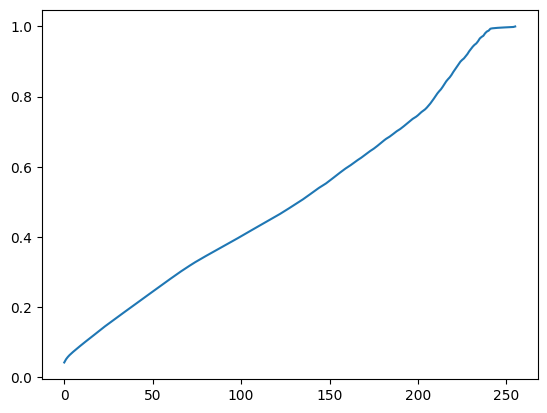

In [124]:
plt.plot(CH[0])
plt.show()

Как видно из результатов графика, преобразование асимптотически линейно

### Листинг 1.5. Экспоненциальное преобразование

C:\Users\Dmitriy Novichkov\AppData\Local\Temp\ipykernel_21640\1025017277.py:16: RuntimeWarning: divide by zero encountered in log
  Inew = np.clip(Imin[i] - 255.0 * (1 / alpha) * np.log(1 - CH[i][image[y][x][i]]), 0, 255)


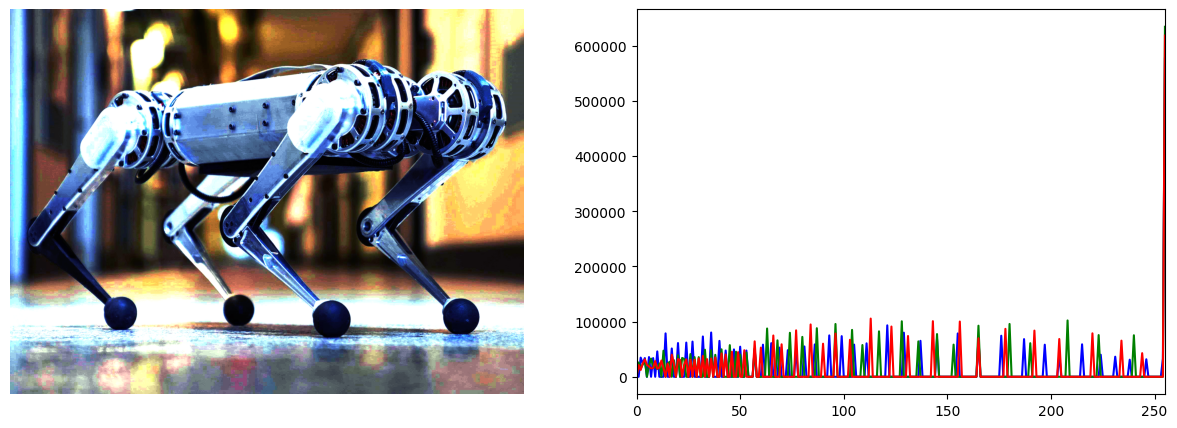

In [133]:
alpha = 1.7

base_hist = []
CH = []

image_BGR = cv2.split(image)

for i, col in enumerate(color):
    base_hist.append(cv2.calcHist(image_BGR, [i], None, [hist_size], hist_range))
    CH.append(np.cumsum(base_hist[i]) / (image.shape[0] * image.shape[1]))

Imin = [np.min(image[:,:,i]) for i in range(image.shape[2])]
image_new = np.zeros(image.shape, dtype="uint8")

for i in range(image.shape[2]):
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            Inew = np.clip(Imin[i] - 255.0 * (1 / alpha) * np.log(1 - CH[i][image[y][x][i]]), 0, 255)

            image_new[y][x][i] = int(round(Inew))

show_image_hist(image_new)

Повысилась контрастность

### Листинг 1.6. Преобразование по закону Рэлея

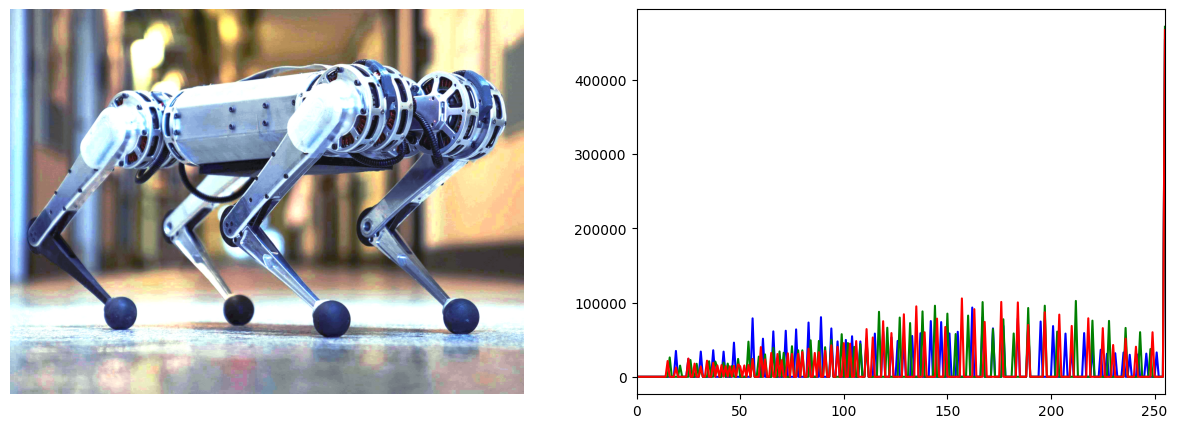

In [135]:
alpha = 0.5

base_hist = []
CH = []

image_BGR = cv2.split(image)

for i, col in enumerate(color):
    base_hist.append(cv2.calcHist(image_BGR, [i], None, [hist_size], hist_range))
    CH.append(np.cumsum(base_hist[i]) / (image.shape[0] * image.shape[1]))

Imin = [np.min(image[:,:,i]) for i in range(image.shape[2])]
image_new = np.zeros(image.shape, dtype="uint8")

for i in range(image.shape[2]):
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            Inew = np.clip((Imin[i] + 255.0 * pow((2 * pow(alpha, 2) * np.log(1 / (1 + 1e-9 - CH[i][image[y][x][i]]))), 0.5)), 0, 255)

            image_new[y][x][i] = int(round(Inew))

show_image_hist(image_new)

Изображение получается ярким и насыщенным, но еще присутствует пик белого на гистограмме

### Листинг 1.7. Преобразование по закону степени 2/3

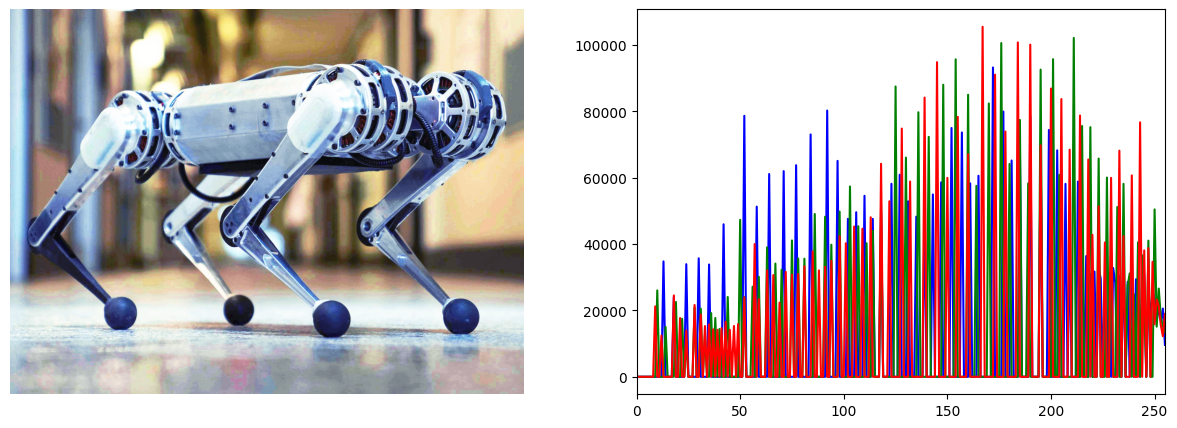

In [137]:
base_hist = []
CH = []

image_BGR = cv2.split(image)

for i, col in enumerate(color):
    base_hist.append(cv2.calcHist(image_BGR, [i], None, [hist_size], hist_range))
    CH.append(np.cumsum(base_hist[i]) / (image.shape[0] * image.shape[1]))

Imin = [np.min(image[:,:,i]) for i in range(image.shape[2])]
image_new = np.zeros(image.shape, dtype="uint8")

for i in range(image.shape[2]):
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
           Inew = 255.0 * pow(CH[i][image[y][x][i]], 2 / 3)

           image_new[y][x][i] = int(round(Inew))

show_image_hist(image_new)

### Листинг 1.8. Гиперболическое преобразование

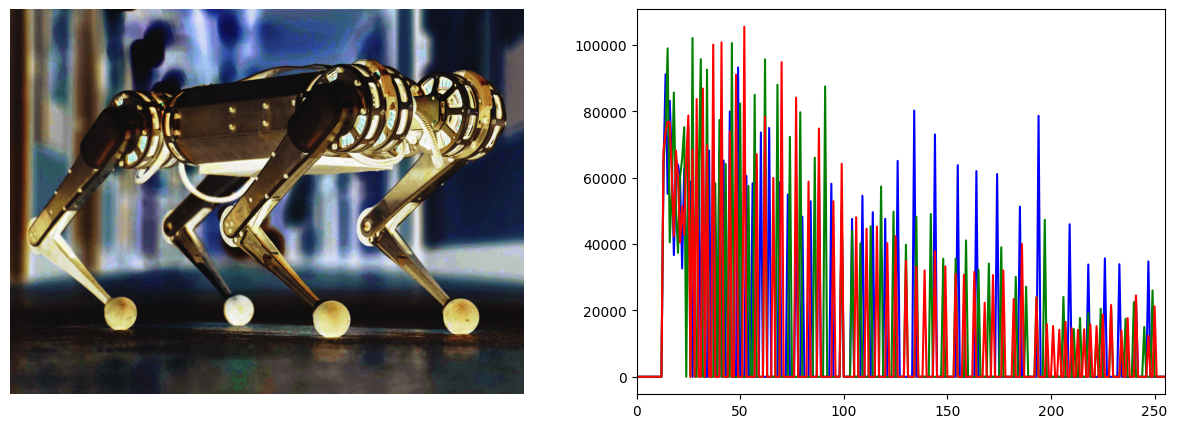

In [142]:
base_hist = []
CH = []

image_BGR = cv2.split(image)

for i, col in enumerate(color):
    base_hist.append(cv2.calcHist(image_BGR, [i], None, [hist_size], hist_range))
    CH.append(np.cumsum(base_hist[i]) / (image.shape[0] * image.shape[1]))

alpha = [np.min(image[:,:,i]) for i in range(image.shape[2])]
image_new = np.zeros(image.shape, dtype="uint8")

for i in range(image.shape[2]):
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
           Inew = 255.0 * pow(alpha[i] + 0.05, CH[i][image[y][x][i]])

           image_new[y][x][i] = int(round(Inew))

show_image_hist(image_new)

Это немного похоже на эффект "Негатив".
Гистограмма интенсивности ведёт себя не постоянно и сильно меняется от изменения коэффициента смещения alpha_bias.

### Листинг 1.9. Эквализация гистограммы

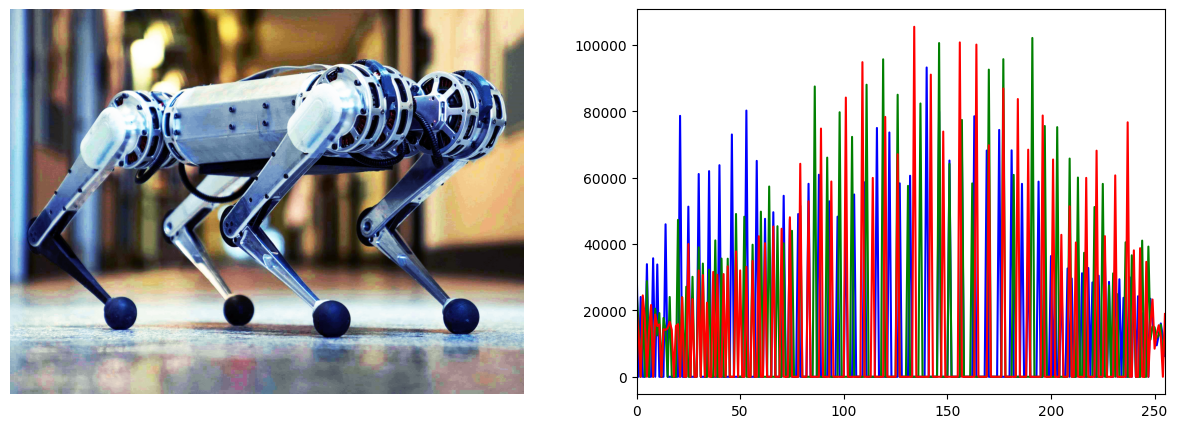

In [164]:
channels = np.array(cv2.split(image))

for i in range(len(channels)):
    channels[i] = cv2.equalizeHist(channels[i])
    
image_equalizeHist = cv2.merge(channels)
show_image_hist(image_equalizeHist)

### Листинг 1.10 Контрастно-ограниченное адаптивное выравнивание гистограммы

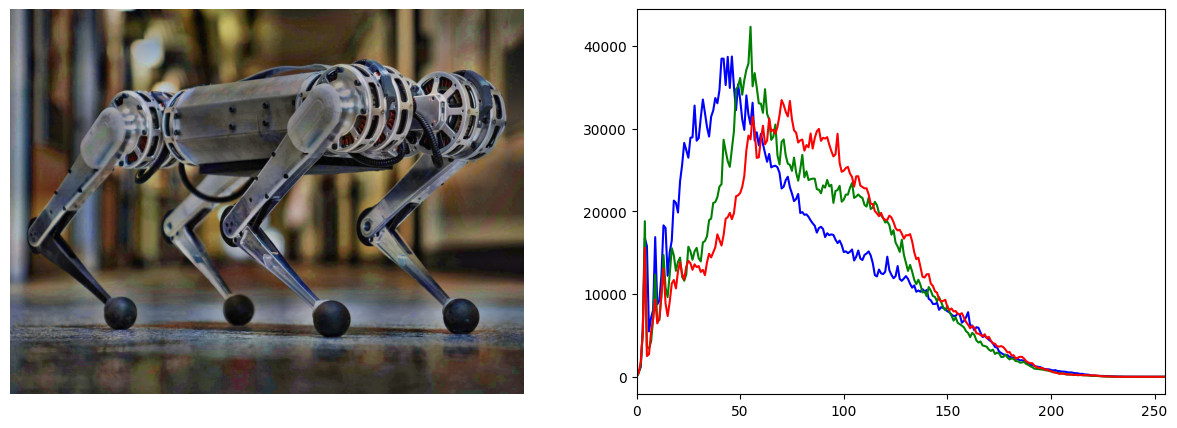

In [166]:
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
channels = np.array(cv2.split(image))

for i in range(len(channels)):
    channels[i] = clahe.apply(channels[i])

image_CLAHE = cv2.merge(channels)
show_image_hist(image_CLAHE)